<div style="height:200px;width:100%;margin: 0;">
    <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/34547/logos/header.png?t=2022-02-15-22-37-27" style="width:100%;" />
</div>

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="credits"><center>Credits</center></h3>

# change log:

|date|comment|cv/lb|outcome|
|-------|-------|-----|----|
|26/08|data pixel and thickness fixed|`0.767`/`0.69`| worked |
|28/08|runned on cutout [data: pixel and thickness fixed]|`0.779` / `0.65`| didn't work |
|28/08|running ~~cutout~~, data stain normed, pixel and thickness fixed| `--`| `--` |


<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="imports"><center>Imports</center></h3>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import time
import random

import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
# from torchmetrics.functional import dice_score
from torch.optim.lr_scheduler import StepLR
import tifffile

is_amp = True
import logging
import pandas as pd
from sklearn.model_selection import KFold

import numpy as np
from itertools import repeat
import collections.abc

In [2]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
# set_seed(42)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="paths"><center>Paths</center></h3>

In [3]:
# !mkdir /kaggle/working/result
# !mkdir /kaggle/working/checkpoint

# root_dir = '.'
# pretrain_dir = '/home/lakshita/somusan/hubmap_kaggle/nbs/swin-tiny-small-22k-pretrained'

# TRAIN = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-22-aug-pixel-size'
# MASKS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks'
# LABELS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv'

# KAGGLE code =---------------------
# !mkdir /kaggle/working/result
# !mkdir /kaggle/working/checkpoint

# root_dir = '/kaggle/working/'
# pretrain_dir = '/kaggle/input/swin-tiny-small-22k-pretrained'

# TRAIN = '../input/hubmap-organ-segmentation/train_images/'
# MASKS = '../input/hacking-the-human-body-annotation-masks/train_binary_masks'
# LABELS = '../input/hubmap-organ-segmentation/train.csv'


# LOCAL code =---------------------
!mkdir -p ./result
!mkdir -p ./checkpoint

root_dir = '.'
pretrain_dir = '/home/lakshita/somusan/hubmap_kaggle/nbs/swin-tiny-small-22k-pretrained'

TRAIN = '/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size'
MASKS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks'
LABELS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv'

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="additionals"><center>Additionals</center></h3>

In [4]:
def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype=torch.float)
    return x


def mask_to_tensor(mask):
    x = mask
    x = torch.tensor(x, dtype=torch.float)
    return x


tensor_list = ['mask', 'image', 'organ']

def null_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        v = [b[k] for b in batch]
        if k in tensor_list:
            v = torch.stack(v)
        d[k] = v

    d['mask'] = d['mask'].unsqueeze(1)
    d['organ'] = d['organ'].reshape(-1)
    return d


def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_2tuple = _ntuple(2)


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

        
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob,3):0.3f}'
    
    
class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    
    
def message(mode='print'):
    asterisk = ' '
    if mode==('print'):
        loss = batch_loss
    if mode==('log'):
        loss = train_loss
        if (iteration % iter_save == 0): asterisk = '*'

    text = \
        ('%0.2e   %08d%s %6.2f | '%(rate, iteration, asterisk, epoch,)).replace('e-0','e-').replace('e+0','e+') + \
        '%4.3f  %4.3f  %4.4f  %4.3f   | '%(*valid_loss,) + \
        '%4.3f  %4.3f   | '%(*loss,) + \
        '%s' % ((time.time() - start_timer))
    print("=---------------------DEBUG")
    print(loss)
    print(loss.shape)
    print("=---------------------DEBUG")

    return text

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="randoms"><center>Random choice</center></h3>

In [5]:
def valid_augment5(image, mask, organ):
    #image, mask  = do_crop(image, mask, image_size, xy=(None,None))
    return image, mask

def train_augment5b(image, mask, organ):
    # image, mask = cutout_custom(image, mask)
    image, mask = do_random_flip(image, mask)
    image, mask = do_random_rot90(image, mask)
    
    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_noise(image, mask, mag=0.1),
        lambda image, mask: do_random_contast(image, mask, mag=0.40),
        lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
    ], 2): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_rotate_scale(image, mask, angle=45, scale=[0.50, 2.0]),
    ], 1): image, mask = fn(image, mask)

    return image, mask

In [6]:
# def albu_aug(p=1.0):
#     return A.Compose([
#         A.HorizontalFlip(),
#         A.VerticalFlip(),
#         A.RandomRotate90(),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
#                          border_mode=cv2.BORDER_REFLECT),
#         A.OneOf([
#             A.OpticalDistortion(p=0.3),
#             A.GridDistortion(p=.1),
#             A.PiecewiseAffine(p=0.3),
#             A.GaussNoise(p=0.3)
#         ], p=0.3),
#         A.OneOf([
#             A.HueSaturationValue(10,15,10),
#             A.CLAHE(clip_limit=2),
#             A.RandomBrightnessContrast(),            
#         ], p=0.3),
#     ], p=p)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="augmentations"><center>Augmentations</center></h3>

In [7]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

import matplotlib.pyplot as plt
def cutout_custom(image, mask, alpha=0.05):
    x=int(alpha*image.shape[0])
    y=int(alpha*image.shape[1])
    ctr_list = []
    for i in range(10):
        ctr_list.append(np.random.randint(0,image.shape[0],size=(2)))
    cut_image=np.copy(image)
    cut_mask=np.copy(mask)
    for center in ctr_list:
        cut_image[center[0]-x//2:center[0]+x//2,center[1]-y//2:center[1]+y//2,:]=0
        cut_mask[center[0]-x//2:center[0]+x//2,center[1]-y//2:center[1]+y//2]=0
    return cut_image, cut_mask
# img = cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"), cv2.COLOR_BGR2RGB)
# msk = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0)
# img_, msk_ = cutout_custom(img,msk)
# plt.figure(figsize=(8,10))
# plt.subplot(2,2,1)
# plt.imshow(img_)
# plt.subplot(2,2,2)
# plt.imshow(msk_)

# plt.subplot(2,2,3)
# plt.imshow(img)
# plt.subplot(2,2,4)
# plt.imshow(msk)
# plt.show()

In [8]:
import torch
import numpy as np


def rand_bbox(size, lam):
    """
    Retuns the coordinate of a random rectangle in the image for cutmix.

    Args:
        size (torch tensor [batch_size x c x W x H): Input size.
        lam (int): Lambda sampled by the beta distribution. Controls the size of the squares.

    Returns:
        int: 4 coordinates of the rectangle.
        int: Proportion of the unmasked image.
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    return bbx1, bby1, bbx2, bby2, lam


def cutmix_data(x, y, alpha=1.0, device="cuda"):
    """
    Applies cutmix to a sample

    Args:
        x (torch tensor [batch_size x input_size]): Input batch.
        y (torch tensor [batch_size x num_classes]): Labels.
        alpha (float, optional): Parameter of the beta distribution. Defaults to 1..
        device (str, optional): Device for torch. Defaults to "cuda".

    Returns:
        torch tensor [batch_size x input_size]: Mixed input.
        torch tensor [batch_size x num_classes]: Mixed labels.
        float: Probability sampled by the beta distribution.
    """
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1

    index = torch.randperm(x.size()[0]).to(device)

    bbx1, bby1, bbx2, bby2, lam = rand_bbox(x.size(), lam)

    mixed_x = x.clone()
    mixed_y = y.clone()

    mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    mixed_y[:, bbx1:bbx2, bby1:bby2] = y[index, bbx1:bbx2, bby1:bby2]

    return mixed_x, mixed_y

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dataset"><center>Dataset</center></h3>

In [9]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [10]:
image_size = 512 #768

class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
#         ids = pd.read_csv(LABELS).id.astype(str).values
#         self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids]
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        #fname = self.fnames[index]
        #img_id = self.df.iloc[index, 'id']
        d = self.df.iloc[index]
        img_height = self.df.loc[index, 'img_height']
        img_width = self.df.loc[index, 'img_width']
        organ = self.organ_to_label[d.organ]
#
        # image = cv2.cvtColor(tifffile.imread(os.path.join(TRAIN, f'{d.id}.tiff')), cv2.COLOR_BGR2RGB)
#         print(os.path.join(TRAIN , f'{d.id}.png'))
        image = cv2.imread(os.path.join(TRAIN , f'{d.id}.png'), cv2.COLOR_BGR2RGB)
        
        rle_mask = self.df.loc[index, 'rle']
        mask = rle_decode(rle_mask, (img_height, img_width))
        #mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = 2)
        #print(mask.shape)
        
        image = image.astype(np.float32)/255
        #mask  = mask.astype(np.float32)/255
        mask = mask.astype(np.float32)

        s = d.pixel_size/0.4 * (image_size/3000)
        image = cv2.resize(image,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask, dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        # print(image.shape, mask.shape)
        if self.augment is not None:
            # print(image.shape, mask.shape)
            image, mask = self.augment(image, mask, organ)


        r ={}
        r["id"] = d.id
        r['index']= index
        r['organ'] = torch.tensor([organ], dtype=torch.long)
        r['image'] = image_to_tensor(image)
        r['mask' ] = mask_to_tensor(mask)
        return r

In [11]:
df = pd.read_csv('/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv')
ds = HubmapDataset(df)
# plt.imshow(ds[0]["image"].permute(1,2,0).detach().numpy()) #(512, 512, 3) (512, 512)
# ds[0]["image"]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="patching"><center>Image Patching</center></h3>

In [12]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """
    def __init__(self,
                 patch_size=4,
                 in_chans=3,
                 embed_dim=96,
                 norm_layer=None
                 ):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape

        # padding
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))


        x = self.proj(x)  # B C Wh Ww
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x
    
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """

        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"


        x = x.view(B, H, W, C)
        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B, H/2, W/2, 4*C
        x = x.view(B, -1, 4 * C)  # B, H/2*W/2, 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="swin"><center>Swin Transformer</center></h3>

In [13]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """
    def __init__(self,
        dim,
        depth,
        num_heads,
        window_size,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop=0.,
        attn_drop=0.,
        drop_path=0.,
        norm_layer=nn.LayerNorm,
        downsample=None,
        #use_checkpoint=False,
    ):
        super().__init__()
        self.window_size = window_size
        self.shift_size = window_size // 2
        self.depth = depth

        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
            )
            for i in range(depth)
        ])
        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, H, W):
        """
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """

        # calculate attention mask for SW-MSA ----
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # 1 Hp Wp 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        #------


        for blk in self.blocks:
            x = blk(x, H, W, attn_mask)

        if self.downsample is not None:
            x_down = self.downsample(x, H, W)
            Wh, Ww = (H + 1) // 2, (W + 1) // 2
            return x, H, W, x_down, Wh, Ww
        else:
            return x, H, W, x, H, W

In [14]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """
    def __init__(self,
        dim,
        num_heads,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop=0.,
        attn_drop=0.,
        drop_path=0.,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)


    def forward(self, x, H, W, mask_matrix):

        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape


        # cyclic shift ---
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, window_size*window_size, C
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)


        # reverse cyclic shift ---
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

In [15]:
class SwinTransformerV1(nn.Module):
    def __init__(self,
        pretrain_img_size=224,
        patch_size=4,
        in_chans=3,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        patch_norm=True,
        out_norm = nn.Identity, #use nn.Identity, nn.BatchNorm2d, LayerNorm2d
        **kwargs
    ):
        super().__init__()
        self.pretrain_img_size = pretrain_img_size
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.mlp_ratio = mlp_ratio


        self.patch_embed = PatchEmbed(
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if patch_norm else None
        )
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = np.linspace(0, drop_path_rate, sum(depths)).tolist() # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i),
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i]):sum(depths[:i + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i < self.num_layers - 1) else None,
            )
            self.layers.append(layer)

        #---
        # add a norm layer for each output
        self.out_norm = nn.ModuleList(
            [ out_norm(int(embed_dim * 2 ** i)) for i in range(self.num_layers)]
        )

        #---
        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward(self, x):
        x = self.patch_embed(x)
        Wh, Ww = x.size(2), x.size(3)

        #positional encode?
        x = x.flatten(2).transpose(1, 2)
        x = self.pos_drop(x)

        outs = []
        for i in range(self.num_layers):
            x_out, H, W, x, Wh, Ww = self.layers[i](x, Wh, Ww)
            out = x_out.view(-1, H, W, int(self.embed_dim * 2 ** i)).permute(0, 3, 1, 2).contiguous()
            out = self.out_norm[i](out)
            outs.append(out)

        return outs

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="window"><center>Window functionalities</center></h3>

In [16]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** (-0.5)

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)


    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """

        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], self.num_heads)
            # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww

        attn = attn + relative_position_bias.unsqueeze(0)


        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'
    
    
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="ann"><center>Upnet + Net + MLP</center></h3>

In [17]:
def conv3x3_bn_relu(in_planes, out_planes, stride=1):
    "3x3 convolution + BN + relu"
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(inplace=True),
    )

In [18]:
class UPerDecoder(nn.Module):
    def __init__(self,
        in_dim=[256, 512, 1024, 2048],
        ppm_pool_scale=[1, 2, 3, 6],
        ppm_dim=512,
        fpn_out_dim=256
    ):
        super(UPerDecoder, self).__init__()

        # PPM ----
        dim = in_dim[-1]
        ppm_pooling = []
        ppm_conv = []

        for scale in ppm_pool_scale:
            ppm_pooling.append(
                nn.AdaptiveAvgPool2d(scale)
            )
            ppm_conv.append(
                nn.Sequential(
                    nn.Conv2d(dim, ppm_dim, kernel_size=1, bias=False),
                    nn.BatchNorm2d(ppm_dim),
                    nn.ReLU(inplace=True)
                )
            )
        self.ppm_pooling   = nn.ModuleList(ppm_pooling)
        self.ppm_conv      = nn.ModuleList(ppm_conv)
        self.ppm_out = conv3x3_bn_relu(dim + len(ppm_pool_scale)*ppm_dim, fpn_out_dim, 1)

        # FPN ----
        fpn_in = []
        for i in range(0, len(in_dim)-1):  # skip the top layer
            fpn_in.append(
                nn.Sequential(
                    nn.Conv2d(in_dim[i], fpn_out_dim, kernel_size=1, bias=False),
                    nn.BatchNorm2d(fpn_out_dim),
                    nn.ReLU(inplace=True)
                )
            )
        self.fpn_in = nn.ModuleList(fpn_in)

        fpn_out = []
        for i in range(len(in_dim) - 1):  # skip the top layer
            fpn_out.append(
                conv3x3_bn_relu(fpn_out_dim, fpn_out_dim, 1),
            )
        self.fpn_out = nn.ModuleList(fpn_out)

        self.fpn_fuse = nn.Sequential(
            conv3x3_bn_relu(len(in_dim) * fpn_out_dim, fpn_out_dim, 1),
        )

    def forward(self, feature):
        f = feature[-1]
        pool_shape = f.shape[2:]

        ppm_out = [f]
        for pool, conv in zip(self.ppm_pooling, self.ppm_conv):
            p = pool(f)
            p = F.interpolate(p, size=pool_shape, mode='bilinear', align_corners=False)
            p = conv(p)
            ppm_out.append(p)
        ppm_out = torch.cat(ppm_out, 1)
        down = self.ppm_out(ppm_out)

        fpn_out = [down]
        for i in reversed(range(len(feature) - 1)):
            lateral = feature[i]
            lateral = self.fpn_in[i](lateral) # lateral branch
            down = F.interpolate(down, size=lateral.shape[2:], mode='bilinear', align_corners=False) # top-down branch
            down = down + lateral
            fpn_out.append(self.fpn_out[i](down))

        fpn_out.reverse() # [P2 - P5]
        fusion_shape = fpn_out[0].shape[2:]
        fusion = [fpn_out[0]]
        for i in range(1, len(fpn_out)):
            fusion.append(
                F.interpolate( fpn_out[i], fusion_shape, mode='bilinear', align_corners=False)
            )
        x = self.fpn_fuse( torch.cat(fusion, 1))

        return x, fusion

In [19]:
class LayerNorm2d(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x
    
def criterion_aux_loss(logit, mask):
    '''here we are resizing mask shape to logits h and w and then bce ----> [-2:] means last two elements'''
    mask = F.interpolate(mask,size=logit.shape[-2:], mode='nearest')
    loss = F.binary_cross_entropy_with_logits(logit,mask)
    return loss

# FOCAL LOSS ----------------
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [20]:
class Net(nn.Module):

    def load_pretrain( self,):

        checkpoint = cfg[self.arch]['checkpoint']
        print('loading %s ...'%checkpoint)
        checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)['model']
        if 0:
            print('in')
            skip = ['relative_coords_table','relative_position_index']
            filtered={}
            for k,v in checkpoint.items():
                if any([s in k for s in skip ]): continue
                filtered[k]=v
            checkpoint = filtered
        print(self.encoder.load_state_dict(checkpoint,strict=False))  #True


    def __init__( self,):
        super(Net, self).__init__()
        self.output_type = ['inference', 'loss']
        self.focal_loss = FocalLoss()
        self.rgb = RGB()
        self.arch = 'swin_tiny_patch4_window7_224'

        self.encoder = SwinTransformerV1(
            ** {**cfg['basic']['swin'], **cfg[self.arch]['swin'],
                **{'out_norm' : LayerNorm2d} }
        )
        encoder_dim =cfg[self.arch]['upernet']['in_channels']
        #[96, 192, 384, 768]

        self.decoder = UPerDecoder(
            in_dim=encoder_dim,
            ppm_pool_scale=[1, 2, 3, 6],
            ppm_dim=512,
            fpn_out_dim=256
        )

        self.logit = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1)
        )
        self.aux = nn.ModuleList([
            nn.Conv2d(256, 1, kernel_size=1, padding=0) for i in range(4)
        ])



    def forward(self, batch):
        x = batch['image']
        B,C,H,W = x.shape
        x = self.rgb(x)
        encoder = self.encoder(x)
        last, decoder = self.decoder(encoder)
        logit = self.logit(last)
        logit = F.interpolate(logit, size=None, scale_factor=4, mode='bilinear', align_corners=False)
        print("logit shape", logit.shape)
        output = {}
        if 'loss' in self.output_type:
            output['bce_loss'] = F.binary_cross_entropy_with_logits(logit,batch['mask'])
            for i in range(4):
                output['aux%d_loss'%i] = criterion_aux_loss(self.aux[i](decoder[i]),batch['mask'])
            output['focal_loss'] = self.focal_loss(logit,batch['mask'])

            print("================================================")
            print(output['bce_loss'], output['focal_loss'])
            print("================================================")

        if 'inference' in self.output_type:
            output['probability'] = torch.sigmoid(logit)

        

        return output

In [21]:
def run_check_net():
    batch_size = 2
    image_size = 512

    #---
    batch = {
        'image' : torch.from_numpy( np.random.uniform(-1,1,(batch_size,3,image_size,image_size)) ).float(),
        'mask'  : torch.from_numpy( np.random.choice(2,(batch_size,1,image_size,image_size)) ).float(),
        'organ' : torch.from_numpy( np.random.choice(5,(batch_size)) ).long(),
    }
    batch = {k:v.cuda() for k,v in batch.items()}

    net = Net().cuda()
    net.load_pretrain()

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            output = net(batch)

    print('batch')
    for k,v in batch.items():
        print('%32s :'%k, v.shape)

    print('output')
    for k,v in output.items():
        if 'loss' not in k:
            print('%32s :'%k, v.shape)
    for k,v in output.items():
        if 'loss' in k:
            print('%32s :'%k, v.item())

In [22]:
class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="configs"><center>Configuration</center></h3>

In [23]:
cfg = dict(

        #configs/_base_/models/upernet_swin.py
        basic = dict(
            swin=dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                mlp_ratio=4.,
                qkv_bias=True,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.3,
                ape=False,
                patch_norm=True,
                out_indices=(0, 1, 2, 3),
                use_checkpoint=False
            ),

        ),

        #configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k.py
        swin_tiny_patch4_window7_224=dict(
            checkpoint = pretrain_dir+'/swin_tiny_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False,
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),

        #/configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k.py
        swin_small_patch4_window7_224_22k=dict(
            checkpoint = pretrain_dir+'/swin_small_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 18, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),
    )

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="folds"><center>Folds</center></h3>

In [24]:
def make_fold(fold=0):
    df = pd.read_csv(LABELS)

    num_fold = 4
    skf = KFold(n_splits = num_fold, shuffle = True,random_state = 42)

    df.loc[:,'fold']=-1
    for f,(t_idx, v_idx) in enumerate(skf.split(X=df['id'], y=df['organ'])):
        df.iloc[v_idx,-1]=f

    #check
    if 0:
        for f in range(num_fold):
            train_df=df[df.fold!=f].reset_index(drop=True)
            valid_df=df[df.fold==f].reset_index(drop=True)

            print('fold %d'%f)
            t = train_df.organ.value_counts().to_dict()
            v = valid_df.organ.value_counts().to_dict()
            for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
                print('%32s %3d (%0.3f)  %3d (%0.3f)'%(k,t.get(k,0),t.get(k,0)/len(train_df),v.get(k,0),v.get(k,0)/len(valid_df)))

            print('')
            zz=0

    train_df=df[df.fold!=fold].reset_index(drop=True)
    valid_df=df[df.fold==fold].reset_index(drop=True)
    return train_df,valid_df

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dice_score"><center>Competition Metric</center></h3>

In [25]:
def compute_dice_score(probability, mask, smooth = 1):
    N = len(probability)
    p = probability.reshape(N,-1)
    t = mask.reshape(N,-1)

    p = p>0.5
    t = t>0.5
    uion = p.sum(-1) + t.sum(-1)
    overlap = (p*t).sum(-1)
    dice = 2*overlap/(uion+0.0001)
    return dice

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="validation"><center>Validation</center></h3>

In [26]:
organ_threshold = {
    'Hubmap': {
        'kidney'        : 0.40,
        'prostate'      : 0.40,
        'largeintestine': 0.40,
        'spleen'        : 0.40,
        'lung'          : 0.10,
    },
    'HPA': {
        'kidney'        : 0.50,
        'prostate'      : 0.50,
        'largeintestine': 0.50,
        'spleen'        : 0.50,
        'lung'          : 0.10,
    },
}

def valid_infer(net):
    infer_ids = {"spleen":1123, "prostate": 12244, "lung": 4301, "largeintestine": 9777, "kidney":15005}
    image_size = 512
    # create a batch
    infer_imgs = []
    img_list = []
    mask_list = []
    for infer_id in infer_ids.values():
        # kaggle changes
        image_org = cv2.imread(os.path.join(TRAIN, f'{str(infer_id)}.png'), cv2.IMREAD_COLOR) # changed
        mask_org = cv2.imread(os.path.join(MASKS, f'{str(infer_id)}.png'), 0)
        image = image_org.astype(np.float32)/255

        H, W, _ = image.shape

        
        image = cv2.resize(image, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)
        image_org = cv2.resize(image_org, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)
        mask_org = cv2.resize(mask_org, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)

        image = image_to_tensor(image)
        image = image.cuda()
        infer_imgs.append(image)
        img_list.append(image_org)
        mask_list.append(mask_org)

    # batch = {
    #     'image':
    #         torch.stack(infer_imgs),
    #     'mask':
    #         torch.stack([mask_to_tensor(msk_gt.reshape(1, image_size, image_size)).cuda() \
    #             for msk_gt in mask_list])
    # }
    batch = {
        'image':
            torch.stack(infer_imgs),
    }
    
    # run model on batch ----------
    net.output_type = ['inference']
    net = net.eval()
    with torch.no_grad():
        with amp.autocast(enabled = is_amp):
            output = net(batch)
    pred = nn.Sigmoid()(output['probability'])
    msks = (pred.permute((0,2,3,1))>0.5).to(torch.uint8).cpu().detach().numpy()
    
    for idx in range(msks.shape[0]):
        pred_msk = msks[idx,:,:,:].reshape(512,512)
        true_msk = mask_list[idx]
        true_img = img_list[idx]

        plt.figure(figsize= (12,14))
        plt.subplot(1,3,1)
        plt.imshow(true_img)
        plt.title("gt img")

        plt.subplot(1,3,2)
        plt.imshow(true_msk)
        plt.title("gt mask")

        plt.subplot(1,3,3)
        plt.imshow(pred_msk)
        plt.title("pred mask")

        plt.show()
    # output = net(batch)
    # pred = nn.Sigmoid()(output['probability'])
    # thr = organ_threshold[data_src][orgun]
    # msks = (pred.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy()


# valid_infer()

In [27]:
def validate(net, valid_loader, debug = False):

    valid_num = 0
    valid_probability = []
    valid_mask = []
    valid_loss = 0

    net = net.eval()
    start_timer = time.time()
    for t, batch in enumerate(valid_loader):

        net.output_type = ['loss', 'inference']
        with torch.no_grad():
            with amp.autocast(enabled = is_amp):
#                 orgun = batch['organ']
                batch_size = len(batch['index'])
                batch['image'] = batch['image'].cuda()
                batch['mask' ] = batch['mask' ].cuda()
                batch['organ'] = batch['organ'].cuda()

                output = net(batch)
                loss0  = output['bce_loss'].mean()
                
        
        valid_probability.append(output['probability'].data.cpu().numpy())
        valid_mask.append(batch['mask'].data.cpu().numpy())
        valid_num += batch_size
        valid_loss += batch_size*loss0.item()

        #debug
        if debug :
            pass
            organ = batch['organ'].data.cpu().numpy()
            image = batch['image']
            mask  = batch['mask']
            probability  = output['probability']

            for b in range(batch_size):
                m = tensor_to_image(image[b])
                t = tensor_to_mask(mask[b,0])
                p = tensor_to_mask(probability[b,0])
                overlay = result_to_overlay(m, t, p )

                text = label_to_organ[organ[b]]
                draw_shadow_text(overlay,text,(5,15),0.7,(1,1,1),1)

                image_show_norm('overlay',overlay,min=0,max=1,resize=1)
                cv2.waitKey(0)

        print('\r %8d / %d  %s'%(valid_num, len(valid_loader.dataset),(time.time() - start_timer)),end='',flush=True)

    
    
    assert(valid_num == len(valid_loader.dataset))

    probability = np.concatenate(valid_probability)
    mask = np.concatenate(valid_mask)

    loss = valid_loss/valid_num

    dice = compute_dice_score(probability, mask)
    dice = dice.mean()
    
    return [dice, loss,  0, 0]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="init"><center>Initialization</center></h3>

In [28]:
def get_learning_rate(optimizer):
    return optimizer.param_groups[0]['lr']

In [29]:
fold = 3

out_dir = root_dir + '/result/upernet-swin-v1-tiny-aux5-768/fold-%d' % (fold)
initial_checkpoint = None
#initial_checkpoint = '../input/swin-10k/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00009975.model.pth'
#initial_checkpoint = '../input/heng-hubmap-fold0-10k/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00009975.model.pth'

start_lr   = 5e-5 #0.0001
batch_size = 8 #32 #32


## setup  ----------------------------------------
for f in ['checkpoint','train','valid','backup'] : os.makedirs(out_dir +'/'+f, exist_ok=True)

    
log = open(out_dir+'/log.train.txt',mode='a')
log.write('\n--- [START %s] %s\n\n' % ('Swin', '-' * 64))
log.write('\n')


## dataset ----------------------------------------
log.write('** dataset setting **\n')

train_df, valid_df = make_fold(fold)

train_dataset = HubmapDataset(train_df, train_augment5b)
valid_dataset = HubmapDataset(valid_df, valid_augment5)

train_loader  = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size  = batch_size,
    drop_last   = True,
    num_workers = 8,
    pin_memory  = False,
    worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
    collate_fn = null_collate,
)

valid_loader = DataLoader(
    valid_dataset,
    sampler = SequentialSampler(valid_dataset),
    batch_size  = 8,
    drop_last   = False,
    num_workers = 4,
    pin_memory  = False,
    collate_fn = null_collate,
)


log.write('fold = %s\n'%str(fold))
log.write('train_dataset : \n%s\n'%(train_dataset))
log.write('valid_dataset : \n%s\n'%(valid_dataset))
log.write('\n')


## net ----------------------------------------
log.write('** net setting **\n')

scaler = amp.GradScaler(enabled = is_amp)
net = Net().cuda()

if initial_checkpoint is not None:
    f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
    start_iteration = f['iteration']
    start_epoch = f['epoch']
    state_dict  = f['state_dict']
    net.load_state_dict(state_dict,strict=False)  #True
else:
    start_iteration = 0
    start_epoch = 0
    net.load_pretrain()


log.write('\tinitial_checkpoint = %s\n' % initial_checkpoint)
log.write('\n')


## optimiser ----------------------------------
if 0: ##freeze
    for p in net.stem.parameters():   p.requires_grad = False
    pass

def freeze_bn(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            m.weight.requires_grad = False
            m.bias.requires_grad = False
            
#freeze_bn(net)

#-----------------------------------------------

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr)

log.write('optimizer\n  %s\n'%(optimizer))
log.write('\n')

#num_iteration = 1000*len(train_loader)
num_iteration = 12000
iter_log   = len(train_loader)*3 #479
iter_valid = iter_log
iter_save  = iter_log
print("when to save model: ",iter_log)

loading /home/lakshita/somusan/hubmap_kaggle/nbs/swin-tiny-small-22k-pretrained/swin_tiny_patch4_window7_224_22k.pth ...
_IncompatibleKeys(missing_keys=['out_norm.0.weight', 'out_norm.0.bias', 'out_norm.1.weight', 'out_norm.1.bias', 'out_norm.2.weight', 'out_norm.2.bias', 'out_norm.3.weight', 'out_norm.3.bias'], unexpected_keys=['norm.weight', 'norm.bias', 'head.weight', 'head.bias', 'layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask'])
when to save model:  99


In [30]:
# train_df

torch.Size([8, 512, 512, 3]) torch.Size([8, 512, 512, 1])


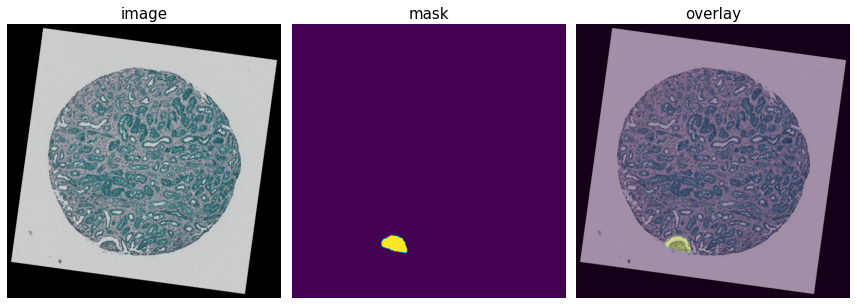

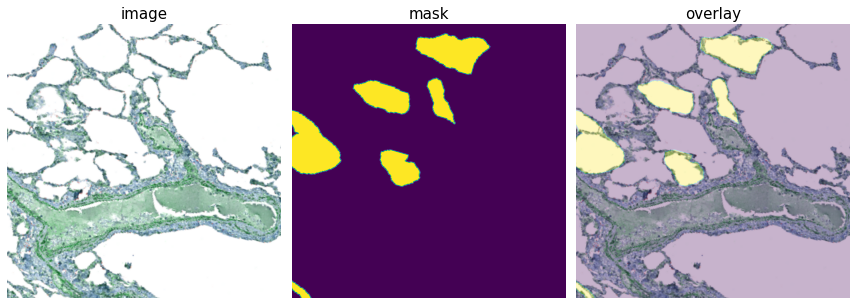

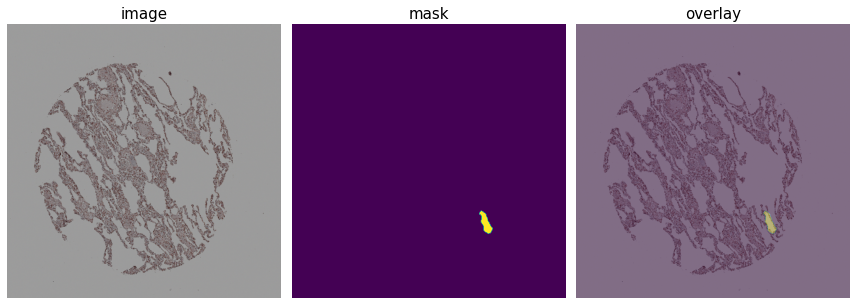

In [31]:
items = next(iter(train_loader))
imgs = items["image"].permute((0, 2, 3, 1))
msks = items["mask"].permute((0, 2, 3, 1))
print(imgs.size(), msks.size())

# torch.unique(msks)

import matplotlib.pyplot as plt
def plot_batch(imgs, msks, size=3):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        plt.subplot(1, 3, 1); plt.imshow(imgs[idx])
        plt.title('image', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 2); plt.imshow(msks[idx])
        plt.title('mask', fontsize=15)
        plt.axis('OFF')
            
        plt.subplot(1, 3, 3); plt.imshow(imgs[idx]); plt.imshow(msks[idx], alpha=0.3)
        plt.title('overlay', fontsize=15)
        plt.axis('OFF')
        
        plt.tight_layout()
        plt.show()

plot_batch(imgs, msks, size=3)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="training"><center>Training</center></h3>

In [32]:
log.write('** start training here! **\n')
log.write('   batch_size = %d \n'%(batch_size))
log.write('                     |-------------- VALID---------|---- TRAIN/BATCH ----------------\n')
log.write('rate     iter  epoch | dice   loss   tp     tn     | loss           | time           \n')
log.write('-------------------------------------------------------------------------------------\n')

valid_loss = np.zeros(4,np.float32)
train_loss = np.zeros(2,np.float32)
batch_loss = np.zeros_like(train_loss)
sum_train_loss = np.zeros_like(train_loss)
sum_train = 0

start_timer = time.time()
iteration = start_iteration
epoch = start_epoch
rate = 0
mix_proba = 0.4
mix_alpha = 0.4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

while iteration < num_iteration:
    for t, batch in enumerate(train_loader):
        
        if iteration%iter_save==0:
            if iteration != start_iteration:
                torch.save({
                    'state_dict': net.state_dict(),
                    'iteration': iteration,
                    'epoch': epoch,
                }, out_dir + '/checkpoint/%08d.model.pth' %  (iteration))
                pass


        if (iteration%iter_valid==0):
            valid_loss = validate(net, valid_loader)
            pass

        # visualize output ------------------
        # if (iteration%1000==0):
        #     valid_infer(net)
        #     pass
            
        if (iteration%iter_log==0) or (iteration%iter_valid==0):
            print('\r', end='', flush=True)
            log.write(message(mode='log') + '\n')

        # apply cutmix ----------------------
#         if np.random.random() > mix_proba:
#             batch['image'], batch['mask'] = cutmix_data(batch['image'], batch['mask'], alpha=mix_alpha, device=device) 


        # learning rate schduler ------------
        rate = get_learning_rate(optimizer)

        # one iteration update  -------------
        batch_size = len(batch['index'])
        
        #print(batch_size, iteration, epoch)
        batch['image'] = batch['image'].half().cuda()
        batch['mask' ] = batch['mask' ].half().cuda()
        batch['organ'] = batch['organ'].cuda()


        net.train()
        net.output_type = ['loss']
        if 1:
            with amp.autocast(enabled = is_amp):
                output = net(batch)
                loss0  = output['bce_loss'].mean()
                loss1  = output['focal_loss'].mean()
                
#                 print(type(output['bce_loss']))
#                 print(type(output['focal_loss']))
            optimizer.zero_grad()
            scaler.scale(loss0+0.2*loss1).backward()

            scaler.unscale_(optimizer)
            scaler.step(optimizer)
            scaler.update()


        print("=-----------------------------")
        print("loss 0",loss0.item())
        print("loss 1",loss1.item())
        print("=-----------------------------")


        # print statistics  --------
        batch_loss[:2] = [loss0.item(),loss1.item()]
        sum_train_loss += batch_loss
        sum_train += 1
        if t % 100 == 0:
            train_loss = sum_train_loss / (sum_train + 1e-12)
            sum_train_loss[...] = 0
            sum_train = 0

        print('\r', end='', flush=True)
        print(message(mode='print'), end='', flush=True)
        epoch += 1 / len(train_loader)
        iteration += 1
    print()    
    torch.cuda.empty_cache()
    
log.write('\n')
log.close()

logit shape torch.Size([8, 1, 512, 512])
tensor(0.7088, device='cuda:0') tensor(0.1462, device='cuda:0')
        8 / 87  4.0861334800720215logit shape torch.Size([8, 1, 512, 512])
tensor(0.7055, device='cuda:0') tensor(0.1446, device='cuda:0')
       16 / 87  4.219699144363403logit shape torch.Size([8, 1, 512, 512])
tensor(0.7101, device='cuda:0') tensor(0.1468, device='cuda:0')
       24 / 87  4.341715335845947logit shape torch.Size([8, 1, 512, 512])
tensor(0.7104, device='cuda:0') tensor(0.1470, device='cuda:0')
       32 / 87  4.480994939804077logit shape torch.Size([8, 1, 512, 512])
tensor(0.7101, device='cuda:0') tensor(0.1469, device='cuda:0')
       40 / 87  5.823458194732666logit shape torch.Size([8, 1, 512, 512])
tensor(0.7108, device='cuda:0') tensor(0.1472, device='cuda:0')
       48 / 87  5.941236972808838logit shape torch.Size([8, 1, 512, 512])
tensor(0.7100, device='cuda:0') tensor(0.1468, device='cuda:0')
       56 / 87  6.046666622161865logit shape torch.Size([8, 1, 512

KeyboardInterrupt: 

In [ ]:
# def image_to_tensor(image, mode='bgr'): #image mode
#     if mode=='bgr':
#         image = image[:,:,::-1]
#     x = image
#     x = x.transpose(2,0,1)
#     x = np.ascontiguousarray(x)
#     x = torch.tensor(x, dtype=torch.float)
#     return x

# def tensor_to_image(x, mode='bgr'):
#     image = x.data.cpu().numpy()
#     image = image.transpose(1,2,0)
#     if mode=='bgr':
#         image = image[:,:,::-1]
#     image = np.ascontiguousarray(image)
#     image = image.astype(np.float32)
#     return image

# def mask_to_tensor(mask):
#     x = mask
#     x = torch.tensor(x, dtype=torch.float)
#     return x

# def tensor_to_mask(x):
#     mask = x.data.cpu().numpy()
#     mask = mask.astype(np.float32)
#     return mask

In [ ]:
# valid_num = 0
# valid_probability = []
# valid_mask = []
# valid_loss = 0

# net = net.eval()
# start_timer = time.time()
# for t, batch in enumerate(valid_loader):

#     net.output_type = ['loss', 'inference']
#     with torch.no_grad():
#         with amp.autocast(enabled = is_amp):

#             batch_size = len(batch['index'])
#             batch['image'] = batch['image'].cuda()
#             batch['mask' ] = batch['mask' ].cuda()
#             batch['organ'] = batch['organ'].cuda()

#             output = net(batch)
#             loss0  = output['bce_loss'].mean()

#     valid_probability.append(output['probability'].data.cpu().numpy())
#     valid_mask.append(batch['mask'].data.cpu().numpy())
#     valid_num += batch_size
#     valid_loss += batch_size*loss0.item()

#     organ = batch['organ'].data.cpu().numpy()
#     image = batch['image']
#     mask  = batch['mask']
#     probability  = output['probability']

#     for b in range(batch_size):
#         m = tensor_to_image(image[b])
#         t = tensor_to_mask(mask[b,0])
#         p = tensor_to_mask(probability[b,0])

In [ ]:
# import matplotlib.pyplot as plt

# plt.imshow(m), m.shape

In [ ]:
# plt.imshow(t), t.shape

In [ ]:
# plt.imshow(p), p.shape